In [1]:
# !pip install -r requirements.txt
# !pip install fbprophet
# !pip install xlrd
# !pip install openpyxl


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
from darts import TimeSeries
from darts.models import (
    FFT,
    ExponentialSmoothing,
    Theta
)
from darts.metrics import mape
from darts.utils.missing_values import fill_missing_values
from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor

plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

[2021-04-27 09:49:48,590] WARNING | darts.models | Support for AutoARIMA is not available. To enable it, install u8darts[pmdarima] or u8darts[all].
[2021-04-27 09:49:48,965] WARNING | darts.models | Support Torch based models not available. To enable it, install u8darts[torch] or u8darts[all].


In [3]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [4]:
data = pd.read_csv('concatenated_data.csv')
data = data[['DateTimeMeasurement','Active']]
data.DateTimeMeasurement = data.DateTimeMeasurement.astype('datetime64[ns]')

data.set_index('DateTimeMeasurement', inplace=True)
data = data.sort_index()
data = data.resample('1h').mean()
data


,Active
DateTimeMeasurement,
2016-04-09 00:00:00,0.0
2016-04-09 01:00:00,0.0
2016-04-09 02:00:00,0.0
2016-04-09 03:00:00,0.0
2016-04-09 04:00:00,0.0
...,...
2020-02-02 19:00:00,0.0
2020-02-02 20:00:00,0.0
2020-02-02 21:00:00,0.0


In [5]:
#data['rolling_1d'] = data['Load (kW)'].shift(24).rolling(24,center=False).mean()
data['rolling_2d'] = data['Active'].shift(48).rolling(48,center=False).mean()
data['rolling_3d'] = data['Active'].shift(72).rolling(72,center=False).mean()
data['rolling_5d'] = data['Active'].shift(120).rolling(120,center=False).mean()
data['rolling_7d'] = data['Active'].shift(168).rolling(168,center=False).mean()
data['time_of_day'] = (np.array(range(len(data)))%24)

,Active,rolling_2d,rolling_3d,rolling_5d,rolling_7d,time_of_day
DateTimeMeasurement,,,,,,
2016-04-09 00:00:00,0.0,NaN,NaN,NaN,NaN,0
2016-04-09 01:00:00,0.0,NaN,NaN,NaN,NaN,1
2016-04-09 02:00:00,0.0,NaN,NaN,NaN,NaN,2
2016-04-09 03:00:00,0.0,NaN,NaN,NaN,NaN,3
2016-04-09 04:00:00,0.0,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...
2020-02-02 19:00:00,0.0,9.924219,11.386458,7.033437,7.875893,19
2020-02-02 20:00:00,0.0,9.924219,11.386458,7.033437,7.875893,20
2020-02-02 21:00:00,0.0,9.924219,11.386458,7.033437,7.875893,21


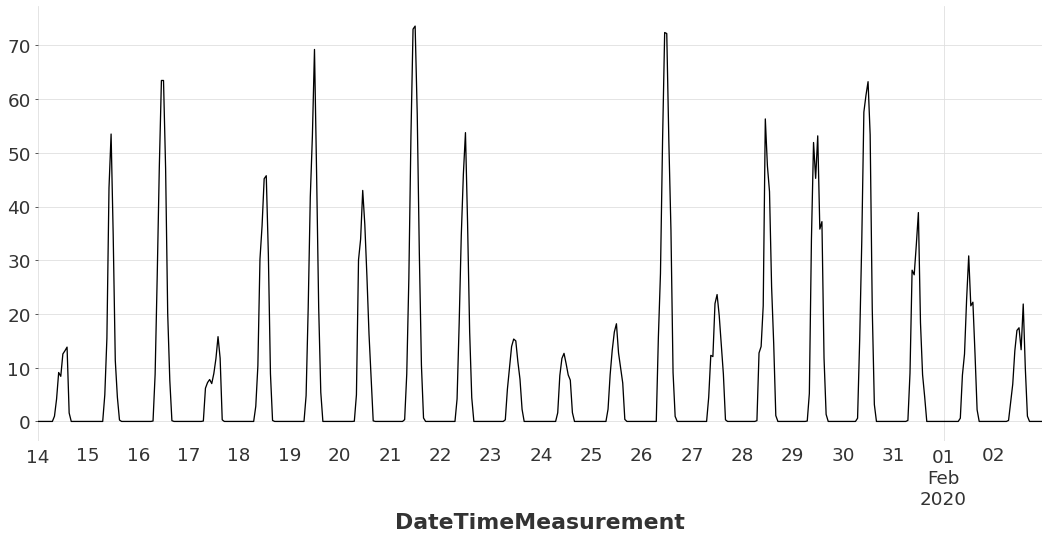

In [6]:
data['Active'].iloc[-480:].plot()
data

In [7]:
data.loc['2018-10-16 07:00:00']

Active         33.412500
rolling_2d     28.560156
rolling_3d     29.491146
rolling_5d     33.690312
rolling_7d     30.233929
time_of_day     7.000000
Name: 2018-10-16 07:00:00, dtype: float64

# Create ES model

In [8]:
# !pip install 'statsmodels==0.12.0' --force-reinstall # --upgrade

In [9]:
# model = ExponentialSmoothing(data['Active'].values[0:480], seasonal_periods=168, 
#                              trend='add', seasonal='mul', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
# forecast_seasonal_Holt = model.forecast(24)
# plt.plot(forecast_seasonal_Holt)

# Define config

In [10]:
startDay = 28
totalDays = 1300
samplingFreq = 24
minimumTrainDuration = samplingFreq * 13
nlags = 360
significantLags = 30
timeHorizon = 24
slidingWindow = True
slidingWindowDays = 28

# Calculate PACF features

In [11]:
def estimateSignificantLags(ts, nlags = 360, significantLags = 11): 
    pacf = sm.tsa.stattools.pacf(ts, nlags)
    lags = np.argsort(-np.abs(pacf))[1:significantLags+1]
    plt.plot(pacf,'*--')
    plt.plot(lags,pacf[lags],'o')
    return lags

[  1   2   3   4   5  11  15  16  17  18  19  20  21  22  23  24  25  26
  27  44  45  46  47  48  49  70  71  72  94  96 118 120 142 144 145 170
 189 194]


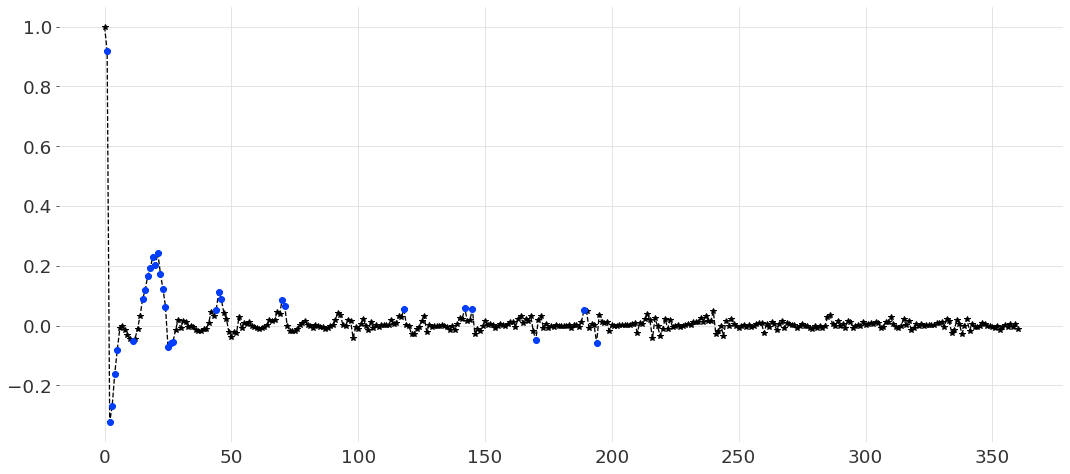

In [12]:
lags = estimateSignificantLags(data['Active'].dropna().iloc[0:8760], significantLags = significantLags)
# add lags for certain days
lags = np.unique(np.hstack([lags,[47,48,49,70,72,94,96,118,120,144]]))
print(np.sort(lags))

# Build a forecaster with lagged features

In [13]:
def add_lag_features(df,lags):
    tmp = df.copy()
    for i in lags:
        tmp['lag_'+str(i)] = tmp['Active'].shift(i)    
    return tmp

In [14]:
lags_df = add_lag_features(data,lags)

## Recursive forecaster

In [15]:
def create_prediction(model_name, start_day='2017-04-07', last_known_day='2018-11-07', 
                      prediction_day='2018-11-08', last_prediction_day='2018-11-09',
                      horizon=48):    
    
    X_train = lags_df.drop(['Active'], axis=1).loc[start_day:last_known_day]
    y_train = lags_df['Active'].loc[start_day:last_known_day]
    #print(X_train,y_train)
    model_name.fit(X_train,y_train)

    pred_index = pd.date_range(start=prediction_day, periods=horizon, freq='H')
    pred_df = pd.DataFrame(index=pred_index, columns=['Active'])
    #print('pred_index',pred_index)
    
    dataCopy = data.copy()
    
    for step in pred_index:
        
        dataCopy = add_lag_features(dataCopy,lags)
        #print(dataCopy.loc[step].name)
        X_pred = pd.DataFrame(dataCopy.drop(['Active'], axis=1).loc[step]).T
        x_index = dataCopy.loc[step].name
        #print(X_pred)
        pred_df.loc[x_index] = model_name.predict(X_pred)
        
        dataCopy.loc[step, 'Active'] = pred_df.loc[x_index][0]

    return pred_df

### Creating a df for all models' outputs:

In [16]:
overall_pred = pd.DataFrame(index=data.index, columns=['CB Model'])
overall_pred

,CB Model
DateTimeMeasurement,
2016-04-09 00:00:00,NaN
2016-04-09 01:00:00,NaN
2016-04-09 02:00:00,NaN
2016-04-09 03:00:00,NaN
2016-04-09 04:00:00,NaN
...,...
2020-02-02 19:00:00,NaN
2020-02-02 20:00:00,NaN
2020-02-02 21:00:00,NaN


In [17]:
n_days = 30

# Create prediction for N days: Catboost

prediction_day 2018-01-01 07:00:00
prediction_day 2018-01-02 07:00:00
prediction_day 2018-01-03 07:00:00
prediction_day 2018-01-04 07:00:00
prediction_day 2018-01-05 07:00:00
prediction_day 2018-01-06 07:00:00
prediction_day 2018-01-07 07:00:00
prediction_day 2018-01-08 07:00:00
prediction_day 2018-01-09 07:00:00
prediction_day 2018-01-10 07:00:00
prediction_day 2018-01-11 07:00:00
prediction_day 2018-01-12 07:00:00
prediction_day 2018-01-13 07:00:00
prediction_day 2018-01-14 07:00:00
prediction_day 2018-01-15 07:00:00
prediction_day 2018-01-16 07:00:00
prediction_day 2018-01-17 07:00:00
prediction_day 2018-01-18 07:00:00
prediction_day 2018-01-19 07:00:00
prediction_day 2018-01-20 07:00:00
prediction_day 2018-01-21 07:00:00
prediction_day 2018-01-22 07:00:00
prediction_day 2018-01-23 07:00:00
prediction_day 2018-01-24 07:00:00
prediction_day 2018-01-25 07:00:00
prediction_day 2018-01-26 07:00:00
prediction_day 2018-01-27 07:00:00
prediction_day 2018-01-28 07:00:00
prediction_day 2018-

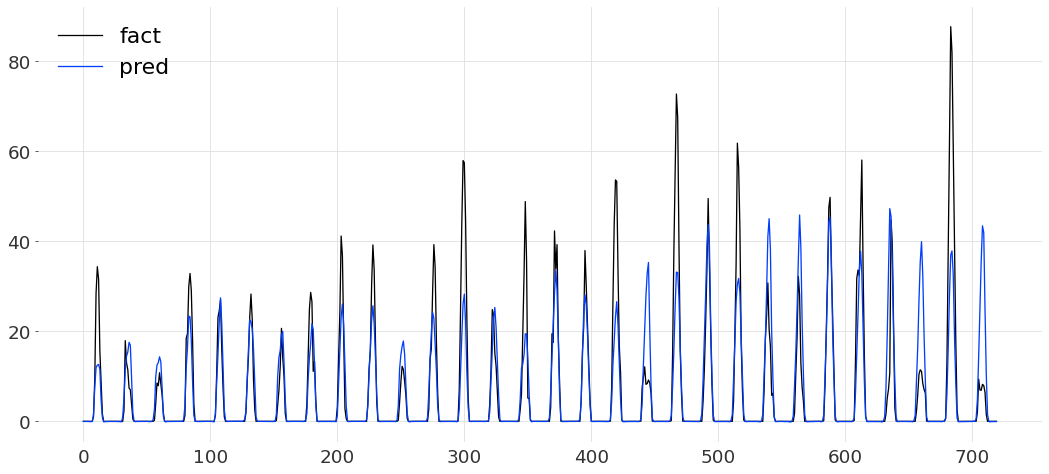

mape 61.63267008397418


In [20]:
model = CatBoostRegressor(verbose=False,
                          learning_rate = 0.01, 
                          depth=6,
                          l2_leaf_reg=4,
                     )

overall_mape = np.zeros(n_days)
start_day = pd.to_datetime('2017-12-01 07:00:00')

for i in range(n_days):

    last_known_day = (start_day + pd.DateOffset(days=30+i))#.date()
    prediction_day = (last_known_day + pd.DateOffset(days=1))#.date()
    last_prediction_day = str((prediction_day + pd.DateOffset(days=1)))#.date())
    print('prediction_day',prediction_day)

    pred = create_prediction(model, start_day=start_day, last_known_day=last_known_day, 
                             prediction_day=prediction_day, last_prediction_day=prediction_day, 
                             horizon = 41)
    
    prediction = pred.dropna()['Active'].values[17:41]
    fact = data.loc[pred.dropna().index,'Active'].values[17:41]

    overall_mape[i] = 100 * np.mean(np.abs(prediction - fact)) / np.mean(np.abs(fact))
    
    overall_pred.loc[pred.index[17:41], 'CB Model'] = pred['Active'].iloc[17:41]
    
plt.plot(data.loc[overall_pred.dropna().index,'Active'].values, label='fact')
plt.plot(overall_pred.dropna()['CB Model'].values, label='pred')
plt.legend()
plt.show()
print('mape',overall_mape.mean())

## Prophet

In [22]:
timeHorizon = 48
startDay = pd.to_datetime('2017-12-02 07:00:00')

for i in range(n_days):

    last_known_day = (startDay + pd.DateOffset(days=30+i))
    prediction_day = (last_known_day + pd.DateOffset(days=1))
    last_prediction_day = str((prediction_day + pd.DateOffset(days=1)))
    
    print('prediction_day (offset 1d)',prediction_day)
    
    df = data[['Active']]
    df['ds'] = df.index
    df['y'] = df['Active']
    df=df.drop(columns = ['Active'])
    
    df=df.loc[last_known_day-pd.DateOffset(days=30):last_known_day]
        
    m = Prophet(daily_seasonality=40, weekly_seasonality=80, changepoint_prior_scale=0.003, yearly_seasonality=False, seasonality_mode='multiplicative', changepoint_range=.9) #, seasonality_prior_scale=100)
#     m = Prophet()
    
    metrics = m.fit(df)
    
    future = m.make_future_dataframe(periods=timeHorizon, freq='1h')
    
    overall_pred.loc[future.ds[-32:-8], 'Prophet_optimized'] = m.predict(future).yhat.iloc[-32:-8].values
    

prediction_day (offset 1d) 2018-01-02 07:00:00
prediction_day (offset 1d) 2018-01-03 07:00:00
prediction_day (offset 1d) 2018-01-04 07:00:00
prediction_day (offset 1d) 2018-01-05 07:00:00
prediction_day (offset 1d) 2018-01-06 07:00:00
prediction_day (offset 1d) 2018-01-07 07:00:00
prediction_day (offset 1d) 2018-01-08 07:00:00
prediction_day (offset 1d) 2018-01-09 07:00:00
prediction_day (offset 1d) 2018-01-10 07:00:00
prediction_day (offset 1d) 2018-01-11 07:00:00
prediction_day (offset 1d) 2018-01-12 07:00:00
prediction_day (offset 1d) 2018-01-13 07:00:00
prediction_day (offset 1d) 2018-01-14 07:00:00
prediction_day (offset 1d) 2018-01-15 07:00:00
prediction_day (offset 1d) 2018-01-16 07:00:00
prediction_day (offset 1d) 2018-01-17 07:00:00
prediction_day (offset 1d) 2018-01-18 07:00:00
prediction_day (offset 1d) 2018-01-19 07:00:00
prediction_day (offset 1d) 2018-01-20 07:00:00
prediction_day (offset 1d) 2018-01-21 07:00:00
prediction_day (offset 1d) 2018-01-22 07:00:00
prediction_da

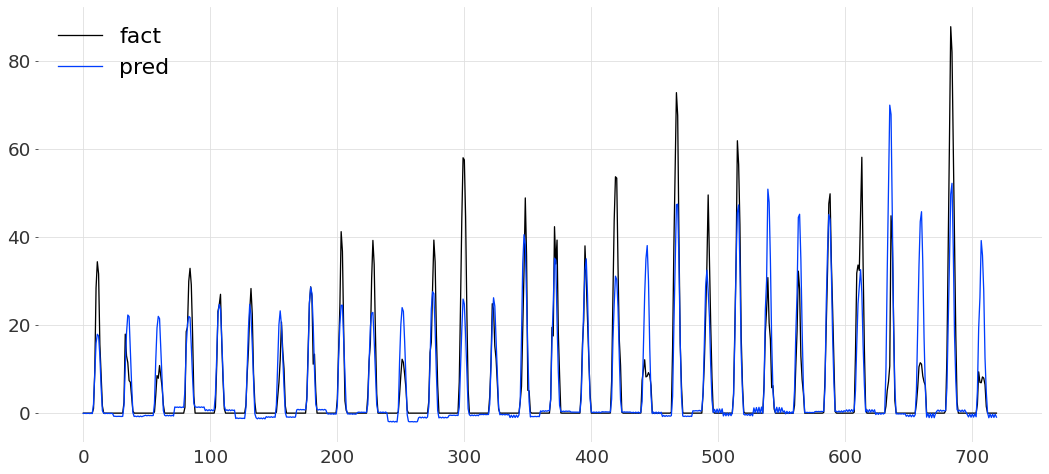

mape 61.63267008397418


In [24]:
plt.plot(data.loc[overall_pred.dropna().index,'Active'].values, label='fact')
plt.plot(overall_pred.dropna()['Prophet_optimized'].values, label='pred')
plt.legend()
plt.show()
print('mape',overall_mape.mean())

# Create prediction for N days: LR

In [26]:
# data = data.drop(['Pressure_kpa','Temperature (C) ','Cloud Cover (%)','Wind Direction (deg)','Wind Speed (kmh)'],axis=1)
lags_df = add_lag_features(data,lags)

prediction_day 2018-01-01 07:00:00
prediction_day 2018-01-02 07:00:00
prediction_day 2018-01-03 07:00:00
prediction_day 2018-01-04 07:00:00
prediction_day 2018-01-05 07:00:00
prediction_day 2018-01-06 07:00:00
prediction_day 2018-01-07 07:00:00
prediction_day 2018-01-08 07:00:00
prediction_day 2018-01-09 07:00:00
prediction_day 2018-01-10 07:00:00
prediction_day 2018-01-11 07:00:00
prediction_day 2018-01-12 07:00:00
prediction_day 2018-01-13 07:00:00
prediction_day 2018-01-14 07:00:00
prediction_day 2018-01-15 07:00:00
prediction_day 2018-01-16 07:00:00
prediction_day 2018-01-17 07:00:00
prediction_day 2018-01-18 07:00:00
prediction_day 2018-01-19 07:00:00
prediction_day 2018-01-20 07:00:00
prediction_day 2018-01-21 07:00:00
prediction_day 2018-01-22 07:00:00
prediction_day 2018-01-23 07:00:00
prediction_day 2018-01-24 07:00:00
prediction_day 2018-01-25 07:00:00
prediction_day 2018-01-26 07:00:00
prediction_day 2018-01-27 07:00:00
prediction_day 2018-01-28 07:00:00
prediction_day 2018-

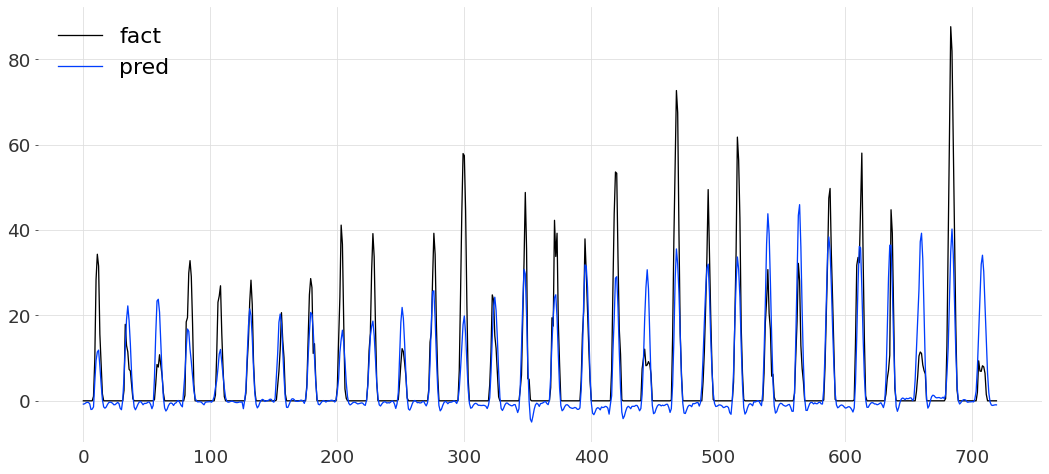

mape 79.71200619498723


In [27]:
model = linear_model.LinearRegression() # Create a linear model object

overall_mape = np.zeros(n_days)
start_day = pd.to_datetime('2017-12-01 07:00:00')

for i in range(n_days):

    last_known_day = (start_day + pd.DateOffset(days=30+i))#.date()
    prediction_day = (last_known_day + pd.DateOffset(days=1))#.date()
    last_prediction_day = str((prediction_day + pd.DateOffset(days=1)))#.date())
    print('prediction_day',prediction_day)

    pred = create_prediction(model, start_day=start_day, last_known_day=last_known_day, 
                             prediction_day=prediction_day, last_prediction_day=prediction_day, 
                             horizon = 41)
    
    prediction = pred.dropna()['Active'].values[17:41]
    fact = data.loc[pred.dropna().index,'Active'].values[17:41]

    overall_mape[i] = 100 * np.mean(np.abs(prediction - fact)) / np.mean(np.abs(fact))
    
    overall_pred.loc[pred.index[17:41], 'LR Model'] = pred['Active'].iloc[17:41]
    
plt.plot(data.loc[overall_pred.dropna().index,'Active'].values, label='fact')
plt.plot(overall_pred.dropna()['LR Model'].values, label='pred')
plt.legend()
plt.show()
print('mape',overall_mape.mean())

In [28]:
overall_pred.dropna()

,CB Model,Prophet_optimized,LR Model
DateTimeMeasurement,,,
2018-01-02 00:00:00,-0.017619,-0.062465,-0.777981
2018-01-02 01:00:00,-0.017693,-0.036717,-0.692281
2018-01-02 02:00:00,-0.022686,-0.077055,-0.475294
2018-01-02 03:00:00,-0.024302,-0.053338,-0.350581
2018-01-02 04:00:00,-0.036755,-0.046496,-0.385016
...,...,...,...
2018-01-31 19:00:00,-0.055855,-0.983999,-0.994511
2018-01-31 20:00:00,-0.051213,-0.230097,-1.084269
2018-01-31 21:00:00,-0.045603,-0.972499,-1.000324


# Make theta prediction

In [29]:
def make_theta_prediction(theta_model, start_day, last_known_day, prediction_day, last_prediction_day, horizon):
    
    series = TimeSeries.from_dataframe(pd.DataFrame(data.loc[start_day:last_prediction_day, 'Active'])) #TimeSeries.from_dataframe(data.reset_index().iloc[start_time-28*24:start_time+nhorizon], 'Time', 'Load (kW)')        
    train, val = series.split_after(pd.Timestamp(last_known_day))
    theta_model.fit(train)
    return theta_model.predict(horizon)


In [30]:
n_horizon = 41
theta_model = Theta(1)
start_day = pd.to_datetime('2017-12-01 07:00:00')

for i in range(n_days):

    last_known_day = (start_day + pd.DateOffset(days=30+i))#.date()
    prediction_day = (last_known_day + pd.DateOffset(days=1))#.date()
    last_prediction_day = str((prediction_day + pd.DateOffset(days=1)))#.date())
    print('prediction_day',prediction_day)
    
    pred = make_theta_prediction(theta_model,
                                   start_day=start_day, 
                                   last_known_day=last_known_day, 
                                   prediction_day=prediction_day, 
                                   last_prediction_day=last_prediction_day, 
                                   horizon=n_horizon)
        
    overall_pred.loc[pred.time_index()[16:40], 'Theta Model'] = pred[16:40].values()
    
plt.plot(data.loc[overall_pred.dropna().index,'Active'].values, label='fact')
plt.plot(overall_pred.dropna()['Theta Model'].values, label='pred')
plt.legend()
plt.show()
print('mape',overall_mape.mean())

prediction_day 2018-01-01 07:00:00


ValueError: Multiplicative seasonality is not appropriate for zero and negative values

In [31]:
overall_pred['LR Model'].dropna()#.plot()#.values[:-40]

DateTimeMeasurement
2018-01-02 00:00:00   -0.777981
2018-01-02 01:00:00   -0.692281
2018-01-02 02:00:00   -0.475294
2018-01-02 03:00:00   -0.350581
2018-01-02 04:00:00   -0.385016
                         ...   
2018-01-31 19:00:00   -0.994511
2018-01-31 20:00:00   -1.084269
2018-01-31 21:00:00   -1.000324
2018-01-31 22:00:00   -0.935813
2018-01-31 23:00:00   -0.954017
Freq: H, Name: LR Model, Length: 720, dtype: object

44.45437457159598

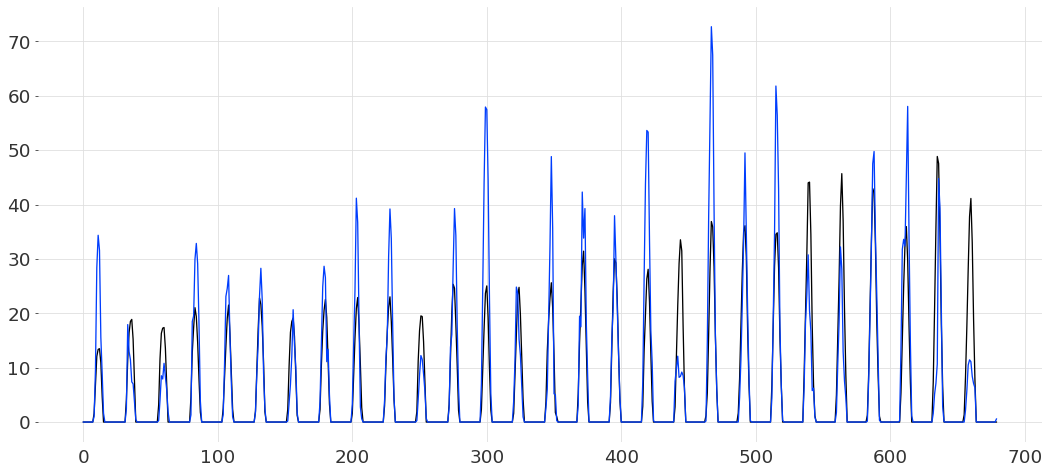

In [82]:
# plt.plot(cb_prediction)
# plt.plot(fact)

prediction = pow(np.abs(cb_prediction * cb_prediction * linearNoWeather_prediction * prophet_prediction), .25)
prediction[np.where(prediction<1)] = 0
plt.plot(prediction)
plt.plot(fact)
100 * np.mean(np.abs(prediction - fact)) / np.mean(np.abs(fact))

# plt.plot((cb_prediction))
# plt.plot((linearNoWeather_prediction))
# plt.plot((prophet_prediction))
# plt.ylim(-1,3)

In [97]:
# plt.plot(fact[0:-1])
# plt.plot(fact[1:])
np.mean(np.abs((data.Active.dropna().values[1:] - data.Active.dropna().values[0:-1])))/np.mean(np.abs(data.Active.dropna().values[0:-1]))


0.34536321578555274

# Comparing models

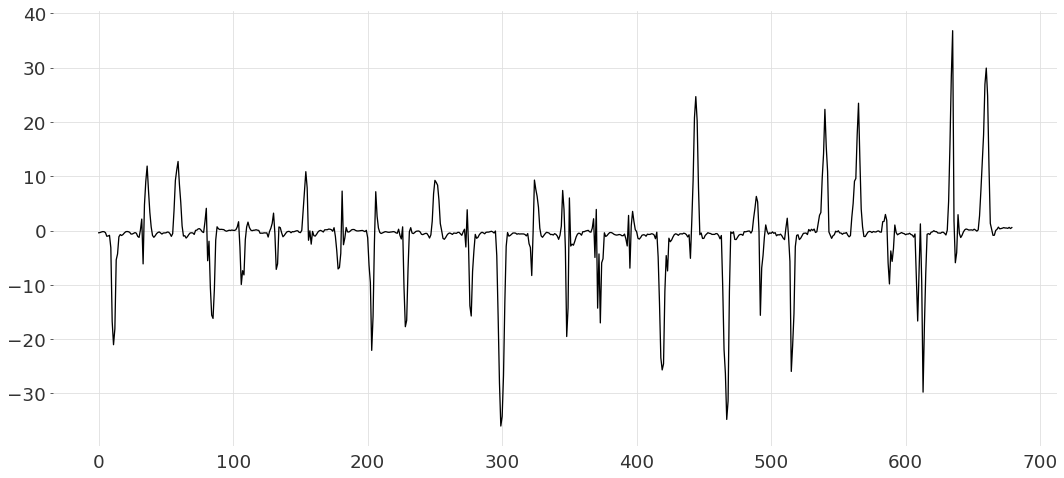

mape Pr: 51.581298021842656
mape CB: 45.15971266350994
mape Linear: 61.43349365727952
mape comb 1: 46.14930633652439
mape comb 2: 53.885841750374084
mape comb 3: 51.60157995002998
mape comb 4 (all - theta): 53.685665620865805
mape comb 6 (no CB): 45.52885446883105
mape pers 2d: 60.36193706697461


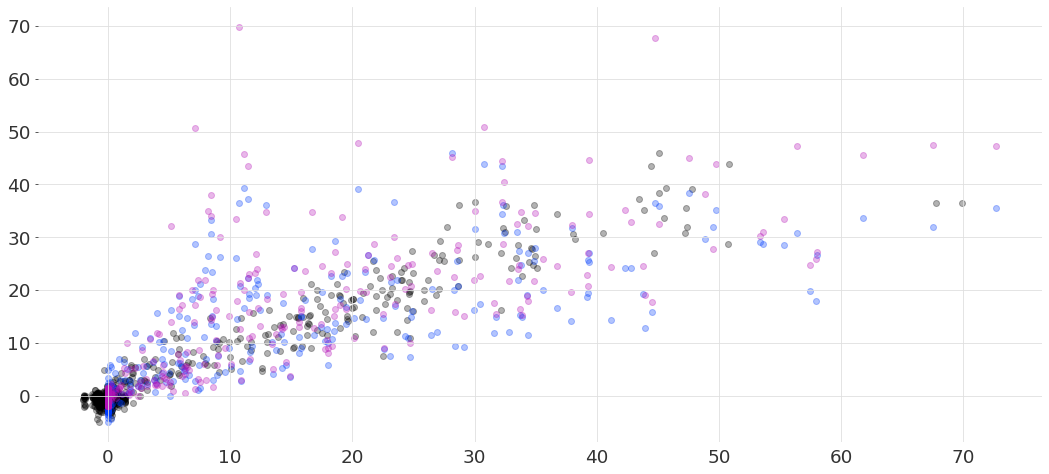

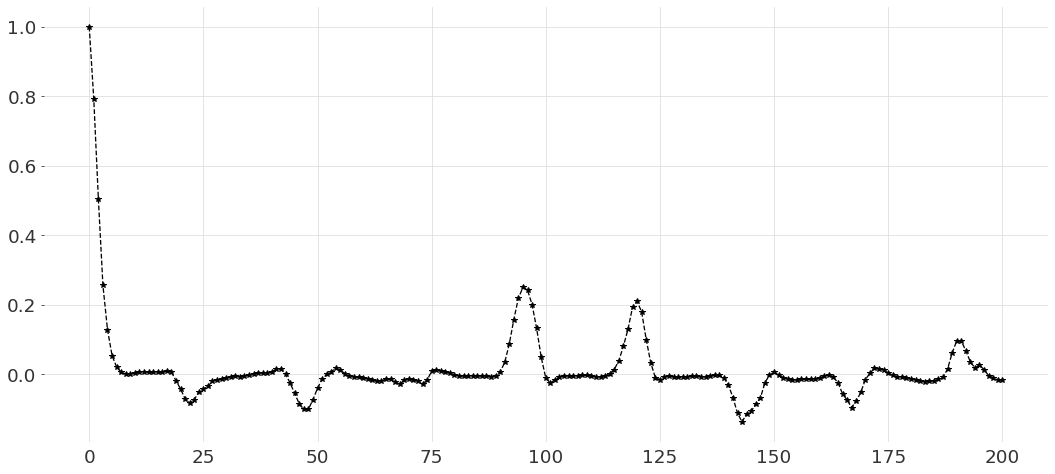

[[1.         0.83112177]
 [0.83112177 1.        ]]
[[1.         0.81878825]
 [0.81878825 1.        ]]
[[1.        0.8412889]
 [0.8412889 1.       ]]


In [39]:
prophet_prediction = overall_pred['Prophet_optimized'].dropna().values[:-40]
fact = data.loc[overall_pred['Prophet_optimized'].dropna().index,'Active'].values[:-40]
linearNoWeather_prediction = overall_pred['LR Model'].dropna().values[:-40]
cb_prediction = overall_pred['CB Model'].dropna().values[:-40]
persistence_2d = data.loc[overall_pred['Prophet_optimized'].dropna().index + pd.DateOffset(days=-2),'Active'].values[:-40]

error = prophet_prediction*.25 + cb_prediction*.25 + linearNoWeather_prediction*.5 - fact
plt.plot(error)
plt.show()

mape_prophet = 100 * np.mean(np.abs(prophet_prediction - fact)) / np.mean(np.abs(fact))
mape_cb = 100 * np.mean(np.abs(cb_prediction - fact)) / np.mean(np.abs(fact))
mape_lin = 100 * np.mean(np.abs(linearNoWeather_prediction - fact)) / np.mean(np.abs(fact))

mape_comb_1 = 100 * np.mean(np.abs(prophet_prediction*.5 + .5*cb_prediction - fact)) / np.mean(np.abs(fact))
mape_comb_2 = 100 * np.mean(np.abs(prophet_prediction*.5 + .5*linearNoWeather_prediction - fact)) / np.mean(np.abs(fact))
mape_comb_3 = 100 * np.mean(np.abs(cb_prediction*.5 + .5*linearNoWeather_prediction - fact)) / np.mean(np.abs(fact))
mape_comb_4 = 100 * np.mean(np.abs(prophet_prediction/5 + cb_prediction/5 + linearNoWeather_prediction*3/5 - fact)) / np.mean(np.abs(fact))
mape_persistence_2d = 100 * np.mean(np.abs(persistence_2d - fact)) / np.mean(np.abs(fact))

mape_comb_6 = 100 * np.mean(np.abs(prophet_prediction*.4 + cb_prediction*.6 - fact)) / np.mean(np.abs(fact))


print('mape Pr:', mape_prophet)
print('mape CB:', mape_cb)
print('mape Linear:', mape_lin)

print('mape comb 1:', mape_comb_1)
print('mape comb 2:', mape_comb_2)
print('mape comb 3:', mape_comb_3)
print('mape comb 4 (all - theta):', mape_comb_4)
print('mape comb 6 (no CB):', mape_comb_6)
print('mape pers 2d:', mape_persistence_2d)

plt.scatter(prophet_prediction, linearNoWeather_prediction, alpha=0.3)
plt.scatter(fact, linearNoWeather_prediction, alpha=0.3)
plt.scatter(fact, prophet_prediction, alpha=0.3)
plt.show()

plt.plot(sm.tsa.stattools.acf(error,nlags=200), '*--')
plt.show()

print(np.corrcoef(prophet_prediction, fact))
print(np.corrcoef(linearNoWeather_prediction.astype('float'), fact))
print(np.corrcoef(cb_prediction.astype('float'), fact))

In [ ]:
data.loc[overall_pred['Prophet'].dropna().index,'Active']


In [ ]:
overall_pred['naive_weekly'].loc['2018-01-01 00:00:00':'2019-01-01 00:00:00'] = data['Active'].loc['2017-12-25 00:00:00':'2018-12-25 00:00:00'].values
overall_pred['fact'] = data.loc[overall_pred['Prophet'].dropna().index,'Active']
overall_pred['ensemble'] = overall_pred['Prophet']*.25 + overall_pred['CB Model']*.2 + overall_pred['Theta Model']*.05 + overall_pred['LR Model']*.35 + overall_pred['naive_weekly']*.15


In [ ]:
overall_pred.dropna().to_csv('data/district/predictions_2018.csv')

# Direct prediction for residuals

In [ ]:
res_X_train = overall_pred.dropna()
res_X_train['Final_model']= res_X_train['Prophet']*.3+res_X_train['CB Model']*.2+res_X_train['Theta Model']*.05+res_X_train['LR Model']*.45
res_y_train = pd.DataFrame(data.loc[res_X_train.index,'Load (kW)'] - res_X_train['Final_model'], columns=['Error'])

In [ ]:
#res_X_val.shape, res_X_train.shape, res_y_train.shape
res_y_train.to_csv('Errors.csv')

In [ ]:
res_X_train.join(data[['day_of_week','time_of_day','is_weekend']])

In [ ]:
def create_direct_prediction(model_name,start_day='2020-10-15', 
                             last_known_day='2020-12-16',
                             prediction_day='2020-12-17'):    
    
    #start=time.time()
    
    y_train = pd.DataFrame(res_y_train.loc[start_day:last_known_day,'Error'])
    X_train = pd.DataFrame(res_X_train.loc[start_day:last_known_day,'Final_model'])
    
    for i in range(16,40):
        y_train['error_'+str(i)] = y_train['Error'].shift(-i).astype('float64')
        X_train['model_'+str(i)] = X_train['Final_model'].shift(-i).astype('float64')
    
    y_train = y_train.dropna().drop(['Error'], axis=1)
    X_train = X_train.dropna().drop(['Final_model'], axis=1).join(data[['day_of_week','time_of_day','is_weekend']])

    #print('y_train',y_train)
    #print('X_train',X_train)
    
    model_name.fit(X_train,y_train)
    
    step = pd.date_range(start=prediction_day, periods=40, freq='H')

    X_pred = pd.DataFrame(res_X_train.loc[step,'Final_model'])
    for i in range(16,40):
        X_pred['model_'+str(i)] = X_pred['Final_model'].shift(-i).astype('float64')
    X_pred = X_pred.dropna().drop(['Final_model'], axis=1).join(data[['day_of_week','time_of_day','is_weekend']])
    
    prediction = model.predict(X_pred)[0]
    #print(X_pred)
    #print('Predict: ', time.time()-start)
    
    return prediction

#model = MultiOutputRegressor(lgb.LGBMRegressor())

#create_direct_prediction(model)

In [ ]:
overall_pred.dropna()

In [ ]:
params = { 'metric': ['l2', 'auc'],
            'learning_rate': 0.005,
            "num_iterations": 200,
            "n_estimators": 200}

model = MultiOutputRegressor(lgb.LGBMRegressor(**params))
#model = MultiOutputRegressor(linear_model.LinearRegression())


overall_mape = np.zeros(n_days)
start_day = pd.to_datetime('2020-11-30 00:00:00')

for i in range(n_days):
    
    last_known_day = (start_day + pd.DateOffset(days=44+i))#.date()
    prediction_day = (last_known_day + pd.DateOffset(days=1))#.date()
    last_prediction_day = str((prediction_day + pd.DateOffset(days=1)))#.date())
    
    pred = create_direct_prediction(model, start_day=start_day, last_known_day=last_known_day, 
                             prediction_day=prediction_day)
    
    print(prediction_day)
    #prediction = pred.dropna()['Load (kW)'].values[17:41]
#    fact = data.loc[pred.dropna().index,'Load (kW)'].values[17:41]

#    overall_mape[i] = 100 * np.mean(np.abs(prediction - fact)) / np.mean(np.abs(fact))
    
    overall_pred.loc[str(prediction_day.date()), 'Direct Error Model'] = pred
    print(pred)
    
    #print(overall_pred.loc[str(prediction_day.date())])
    
plt.plot(data.loc[overall_pred.dropna().index,'Load (kW)'].values, label='fact')
plt.plot(overall_pred.dropna()['Direct Error Model'].values, label='pred')
plt.legend()
plt.show()
#print('mape',overall_mape.mean())

In [ ]:
plt.plot(overall_pred['Direct Error Model'].dropna()[:-16], label='error_pred')
plt.plot(res_y_train.loc[overall_pred['Direct Error Model'].dropna().index,'Error'], label='error_fact')
plt.legend()

In [ ]:
np.corrcoef(overall_pred['Direct Error Model'].dropna().values[:-16].astype('float64'),
     res_y_train.loc[overall_pred['Direct Error Model'].dropna().index,'Error'].dropna().values.astype('float64'))

In [ ]:
plt.plot(data.loc[overall_pred.dropna().index,'Load (kW)'].values, label='fact')
plt.plot(overall_pred.dropna()['CB Model'].values, label='CB Model')
plt.plot(overall_pred.dropna()['Prophet'].values, label='Prophet')
plt.plot(overall_pred.dropna()['LR Model'].values, label='LR Model')
plt.plot(overall_pred.dropna()['Theta Model'].values, label='Theta Model')
#plt.plot(overall_pred.dropna()['Direct RF Model'].values, label='Direct RF Model')
plt.legend()
plt.xlim(800,1300)
plt.show()
print('mape',overall_mape.mean())

In [ ]:
'''overall_pred.dropna().iloc[-192:,:].plot()
overall_pred.dropna().iloc[-192:,:].mean(axis=1).plot(lw=5)
plt.plot(fact,color='red')
plt.show()
# overall_pred = overall_pred.dropna()

plt.plot(prophet_prediction*.25 + cb_prediction*.25 + theta_prediction*.05 + linearNoWeather_prediction*.45,color='black')
plt.plot(prophet_prediction,color='black',alpha=0.3)
plt.plot(cb_prediction,color='black',alpha=0.3)
plt.plot(linearNoWeather_prediction,color='black',alpha=0.3)
plt.plot(theta_prediction,color='black',alpha=0.3)
plt.plot(fact,color='red')
plt.xlim(900,1170)
plt.show()'''

# Make single forecast from ensemble

In [ ]:
prophet_prediction = overall_pred['Prophet'].dropna().iloc[-24:].values
linearNoWeather_prediction = overall_pred['LR Model'].dropna().iloc[-24:].values
cb_prediction = overall_pred['CB Model'].dropna().iloc[-24:].values
theta_prediction = overall_pred['Theta Model'].dropna().iloc[-24:].values

benchmark = data.loc['2021-01-30','Load (kW)'].values

final_prediction = prophet_prediction*.2 + cb_prediction*.15 + theta_prediction*.05 + linearNoWeather_prediction*.3+benchmark*.3

plt.plot(final_prediction,lw=3)
plt.plot(prophet_prediction,label='pr')
plt.plot(linearNoWeather_prediction,label='lin')
plt.plot(cb_prediction,label='cb')
plt.plot(theta_prediction,label='th')
plt.plot(benchmark, label='benchmark')
plt.legend()

np.savetxt('Submitted_Predictions/February-06-Kazmi-Hussain.csv', final_prediction)


In [ ]:
jan19 = pd.read_csv('Submitted_Predictions/February-04-Kazmi-Hussain.csv', header=None)
jan19['fact'] = data.loc['2021-02-04','Load (kW)'].values
jan19 = jan19.dropna()
jan19.plot()

In [ ]:
np.mean(np.abs(jan19[0] - jan19['fact']))# / np.mean(np.abs(jan19['fact']))

In [ ]:
np.mean(np.abs(data['Load (kW)'].loc['2021-01-18':'2021-01-23'].values - data['Load (kW)'].loc['2021-01-11':'2021-01-16'].values))

In [ ]:
fact = data.loc[overall_pred['Prophet'].dropna().index,'Load (kW)'].values[:-40]

In [ ]:
overall_pred.to_csv('overall_pred.csv')

In [ ]:
all_prophet_prediction = overall_pred['Prophet'].dropna()
all_linearNoWeather_prediction = overall_pred['LR Model'].dropna()
all_cb_prediction = overall_pred['CB Model'].dropna()
all_theta_prediction = overall_pred['Theta Model'].dropna()

# all_benchmark = data.loc['2021-01-27','Load (kW)'].values

all_final_prediction = all_prophet_prediction*.3 + all_cb_prediction*.25 + all_theta_prediction*.05 + all_linearNoWeather_prediction*.4


In [ ]:
plt.plot(all_final_prediction.iloc[:-40], label='pred')
plt.plot(data.loc[all_final_prediction.index[:-40], 'Load (kW)'], label='fact')
plt.legend()

In [ ]:
plt.scatter(all_final_prediction.iloc[:-40], data.loc[all_final_prediction.index[:-40], 'Load (kW)'])

np.corrcoef(all_final_prediction.iloc[:-40].values.astype('float'), data.loc[all_final_prediction.index[:-40], 'Load (kW)'].values.astype('float'))

In [ ]:
error = all_final_prediction.iloc[:-40].values.astype('float') - data.loc[all_final_prediction.index[:-40], 'Load (kW)'].values.astype('float')

plt.plot(sm.tsa.stattools.pacf(error, nlags=200),'*--')

In [ ]:
plt.plot(error)

# Define a mixture of experts model

In [ ]:
y = data.loc[overall_pred.dropna().index,'Load (kW)'].dropna()
X = overall_pred.loc[y.index]

X['CB Model'] = X['CB Model'].astype('float')
X['LR Model'] = X['LR Model'].astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

# X

In [ ]:
mixture_model = lgb.LGBMRegressor()#n_estimators = 2000)
mixture_model = linear_model.LinearRegression()
mixture_model.fit(X_train,y_train)

y_pred = mixture_model.predict(X_test)

# plt.scatter(y_test, X_test['LR Model'])
# plt.scatter(y_test, y_pred)

# print(np.corrcoef(y_test, X_test['LR Model']))
# print(np.corrcoef(y_test, y_pred))

# print(np.mean(np.abs(y_test - X_test['LR Model'])))
# print(np.mean(np.abs(y_test - .05*X_test['Theta Model'] -.45*X_test['LR Model'] - .25*X_test['CB Model'] -.25*X_test['Prophet'])))
# print(np.mean(np.abs(y_test - y_pred)))

# mixture_model.coef_